In this Post, we will cover in detail what we do in various steps involved in creating a machine learning (ML) model. I was looking around some ML project which is not very complex but covers all the concepts in creating ML model. I found one good project in kaggle which I am using here as an example and the complete project can be found [here](https://www.kaggle.com/niklasdonges/end-to-end-project-with-python/data). Notebook find and test files can also be downloaded from my [git repository](https://github.com/kumardh/python-practice/tree/master/ML-2).

Let's start with Problem Statement: 

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard the ship, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. 

We are createing a Model which provides information on the fate of passengers on the Titanic would have been survived or not, according to economic status (class), sex, age etc. Here, we can guess this belongs to Classification Supervised Learning as traning data is labeled with the result and we need to categorized to "survied" or "not survived".

# **Import Libraries**

In [63]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# Data Gathering

In our example we already have traning/test data available as csv file which we can load using Panda library. In complex ML projects you might get data for various sources that you will be loading and aggregating it to a single training DataFrame.

In [64]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# Data Pre-processing

Next step is to analyze Data and for this we some very helpful methods available in Pandas.

In [ ]:
train_df.info()
train_df.describe()
train_df.head(10)

Info says, we have 891 records and 11 features with target result (survived) We also get type of the features.
Describe says, 38% survived, age range between .4 to 80. Also we some missing values in some features like 'Age'.

Also, lot of features needs to convert into numeric ones , so that the ml algorithms can process them. Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.

Let's take a more detailed look at what data is actually missing:

In [ ]:
total = train_df.isnull().sum()
percent = train_df.isnull().sum()/train_df.isnull().count()*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
missing_data.sort_values(by=['Total'], ascending=False)

**1. Age and Sex:**

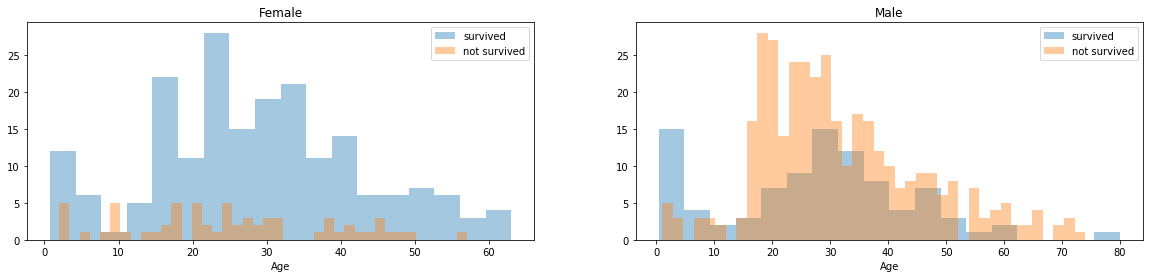

In [67]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

From the plot we can guess the probability of survival is more between 15 to 40 for both Male and Female. Infant survival rate is also high. So It's better to create a new feature as group Age.

**2. Embarked, Pclass  and Sex:**

c:\program files (x86)\python37-32\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


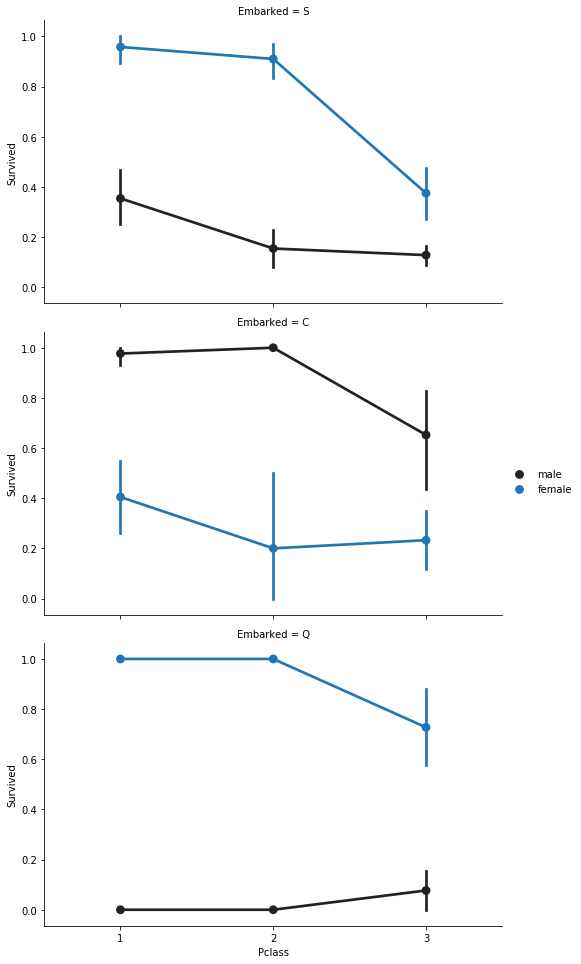

In [68]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender. Women on port Q and S have a higher chance of survival. Men have a high survival probability if they are on port C.

**3. Pclass:**

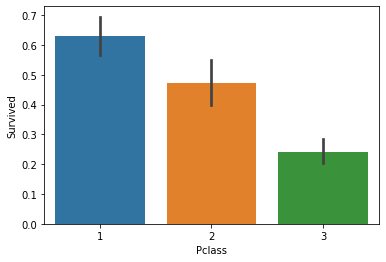

In [69]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

Clearly, class 1 has high probability of survival.

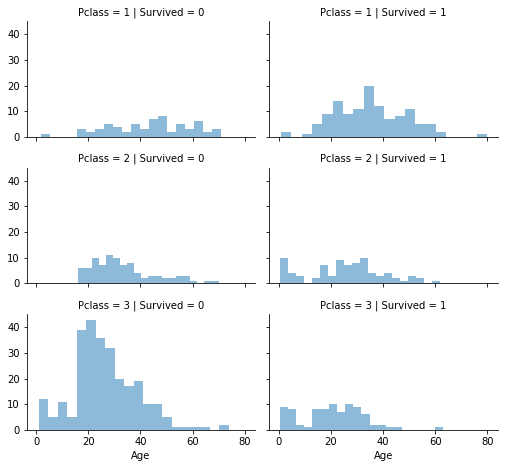

In [70]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

**5.  SibSp and Parch:**

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that sows if someone is not alone.

In [71]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

In [ ]:
train_df['not_alone'].value_counts()

c:\program files (x86)\python37-32\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


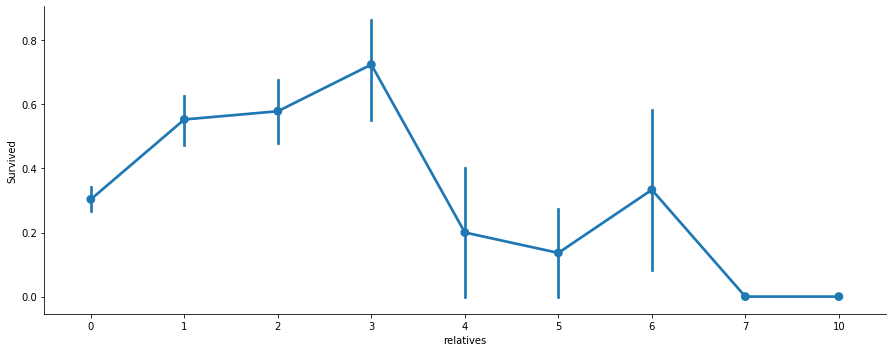

In [73]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

Alright, lets drop features that are not related like PassengetId.

In [74]:
train_df = train_df.drop(['PassengerId'], axis=1)

## Missing Data:

First we decided to delete Cabin but later we realized 1st letter of Cabin represent deck and important feature to be considered. And therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero.

In [75]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 

In [76]:
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

Now we can tackle the issue with the age features missing values. I will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.

In [77]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one S.

In [ ]:
train_df['Embarked'].describe()

In [79]:
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

## Converting Features:

In [ ]:
train_df.info()

Above you can see that 'Fare' is a float and we have to deal with 4 categorical features: Name, Sex, Ticket and Embarked. Lets investigate and transfrom one after another.

Converting "Fare" from float to int64, using the "astype()" function pandas provides:

In [81]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

We will use the Name feature to extract the Titles from the Name, so that we can build a new feature out of that.

In [82]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)

In [83]:
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

Convert 'Sex' feature into numeric.

In [84]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [85]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

Convert 'Embarked' feature into numeric.

In [86]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Creating Categories:

We will now create categories within the following features:

### Age:
Now we need to convert the 'age' feature. First we will convert it from float into integer. Then we will create categorize age to group such a way that the numbers are equally distributed.

In [87]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [ ]:
# let's see how it's distributed
train_df['Age'].value_counts()

### Fare:
For the 'Fare' feature, we need to do the same as with the 'Age' feature.  But it isn't that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn "qcut()" function, that we can use to see, how we can form the categories.

In [90]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# Creating new Features

I will add two new features to the dataset, that I compute out of other features.

### 1. Age times Class

In [91]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

### 2.  Fare per Person

In [92]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

# **Building Machine Learning Models**

In [94]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [95]:
# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)


print(round(acc_sgd,2,), "%")

69.02 %


In [96]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.7 %


In [97]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(round(acc_log,2,), "%")

81.37 %


c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [98]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(round(acc_knn,2,), "%")

87.21 %


In [99]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(round(acc_gaussian,2,), "%")

76.88 %


In [100]:
# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(round(acc_perceptron,2,), "%")

81.48 %


c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [101]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(round(acc_linear_svc,2,), "%")

81.03 %


c:\program files (x86)\python37-32\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [102]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

92.7 %


##  Which is the best Model ?

In [123]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')

You will see the Random Forest classifier goes on the first place. But first, let us check, how random-forest performs, when we use cross validation. 

## K-Fold Cross Validation:

K-Fold Cross Validation randomly splits the training data into **K subsets called folds**. Let's image we would split our data into 4 folds (K = 4).  Our random forest model would be trained and evaluated 4 times, using a different fold for evaluation everytime, while it would be trained on the remaining 3 folds. 

The image below shows the process, using 4 folds (K = 4). Every row represents one training + evaluation process. In the first row, the model get's trained on the first, second and third subset and evaluated on the fourth. In the second row, the model get's trained on the second, third and fourth subset and evaluated on the first. K-Fold Cross Validation repeats this process till every fold acted once as an evaluation fold.

The result of our K-Fold Cross Validation example would be an array that contains 4 different scores. We then need to compute the mean and the standard deviation for these scores. 

The code below perform K-Fold Cross Validation on our random forest model, using 10 folds (K = 10). Therefore it outputs an array with 10 different scores.

In [104]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")

In [105]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76666667 0.83333333 0.76404494 0.80898876 0.88764045 0.84269663
 0.79775281 0.7752809  0.84269663 0.84090909]
Mean: 0.8160010214504597
Standard Deviation: 0.0382778650247283


This looks much more realistic than before.  Our model has a average accuracy of 82% with a standard deviation of 4 %. The standard deviation shows us, how precise the estimates are . 

This means in our case that the accuracy of our model can differ **+ -** 4%.

I think the accuracy is still really good and since random forest is an easy to use model, we will try to increase it's performance even further in the following section.

## Feature Importance

Another great quality of random forest is that  they make it very easy to measure the relative importance of each feature. Sklearn measure a features importance by looking at how much the treee nodes, that use that feature, reduce impurity on average (across all trees in the forest). It computes this score automaticall for each feature after training and scales the results  so that the sum of all importances is equal to 1.  We will acces this below:

In [106]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

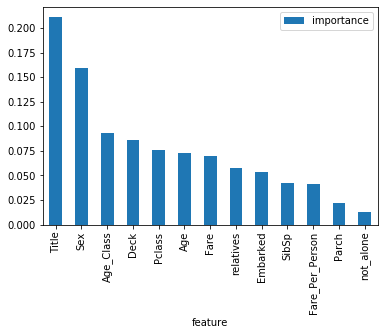

In [108]:
importances.plot.bar()

**Conclusion:**

not_alone and Parch doesn't play a significant role in our random forest classifiers prediction process. Because of that I will drop them from the dataset and train the classifier again. We could also remove more or less features, but this would need a more detailed investigation of the features effect on our model. But I think it's just fine to remove only Alone and Parch.

In [109]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

**Training random forest again:**

In [110]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.7 %


Our random forest model predicts as good as it did before. A general rule is that,  **the more features you have, the more likely your model will suffer from overfitting** and vice versa. But I think our data looks fine for now and hasn't too much features.

There is also another way to evaluate a random-forest classifier, which is probably much more accurate than the score we used before. What I am talking about is the **out-of-bag samples** to estimate the generalization accuracy. I will not go into details here about how it works. Just note that out-of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate removes the need for a set aside test set.

In [111]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 82.38 %


Now we can start tuning the hyperameters of random forest. 

## Hyperparameter Tuning

Below you can see the code of the hyperparamter tuning for the parameters criterion, min_samples_leaf, min_samples_split and n_estimators. 

I put this code into a markdown cell and not into a code cell, because it takes a long time to run it. Directly underneeth it, I put a screenshot of the gridsearch's output.

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
              "n_estimators": [100, 400, 700, 1000, 1500]}


from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid,
                    n_jobs=-1)

clf.fit(X_train, Y_train)        

clf.best_params_

**Test new paramters:**

In [112]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 82.15 %


Now that we have a proper model, we can start evaluating it's performace in a more accurate way. Previously we only used accuracy and the oob score, which is just another form of accuracy. The problem is just, that it's more complicated to evaluate a classification model than a regression model. We will talk about this in the following section.

# **Further Evaluation**



## Confusion Matrix:

In [113]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[490,  59],
       [ 91, 251]], dtype=int64)

The first row is about the not-survived-predictions: **493 passengers were correctly classified as not survived** (called true negatives)  and **56 where wrongly classified as not survived** (false negatives).

The second row is about the survived-predictions: **93 passengers where wrongly classified as survived** (false positives) and **249 where correctly classified as survived** (true positives).

A confusion matrix gives you a lot of information about how well your model does, but theres a way to get even more, like computing the classifiers precision.

## Precision and Recall:

In [114]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.8096774193548387
Recall: 0.7339181286549707


Our model predicts 81% of the time, a passengers survival correctly (precision). The recall tells us that it predicted the survival of 73 % of the people who actually survived. 

## F-Score

You can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [115]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.7699386503067485

There we have it, a 77 % F-score. The score is not that high, because we have a recall of 73%.

But unfortunately the F-score is not perfect, because it favors classifiers that have a similar precision and recall. This is a problem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, sometimes results in an decreasing recall and vice versa (depending on the threshold). This is called the precision/recall tradeoff. We will discuss this in the following section.


## Precision Recall Curve

For each person the Random Forest algorithm has to classify, it computes a probability based on a function and it classifies the person as survived (when the score is bigger the than threshold) or as not survived (when the score is smaller than the threshold). That's why the threshold plays an important part.

We will plot the precision and recall with the threshold using matplotlib:

In [116]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)

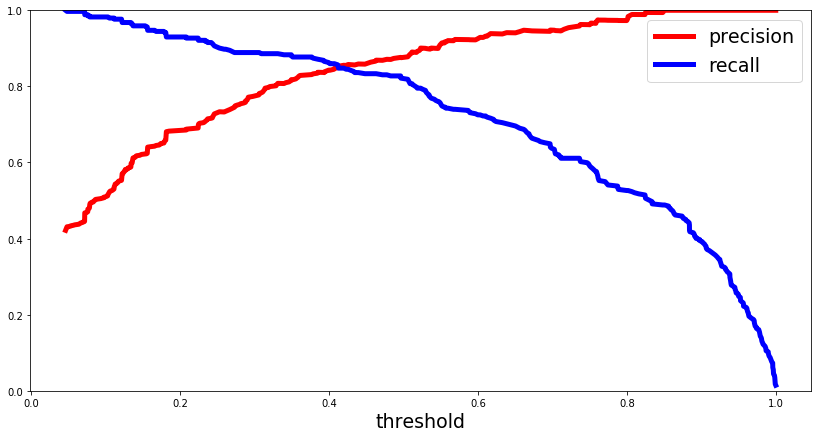

In [117]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Above you can clearly see that the recall is falling of rapidly at a precision of around 85%.  Because of that you may want to select the precision/recall tradeoff before that - maybe at around 75 %.

You are now able to choose a threshold, that gives you the best precision/recall tradeoff for your current machine learning problem. If you want for example a precision of 80%, you can easily look at the plots and see that you would need a threshold of around 0.4.  Then you could train a model with exactly that threshold and would get the desired accuracy.


Another way is to plot the precision and recall against each other:

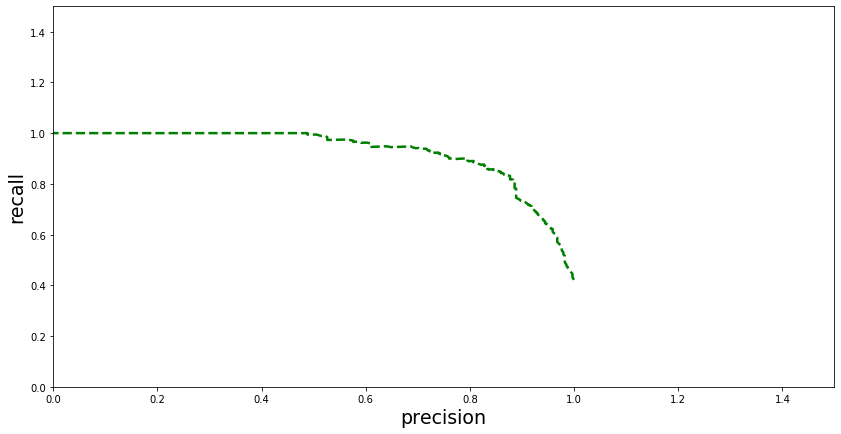

In [118]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

## ROC AUC Curve

Another way to evaluate and compare your binary classifier is provided by the ROC AUC Curve. This curve plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.

In [119]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

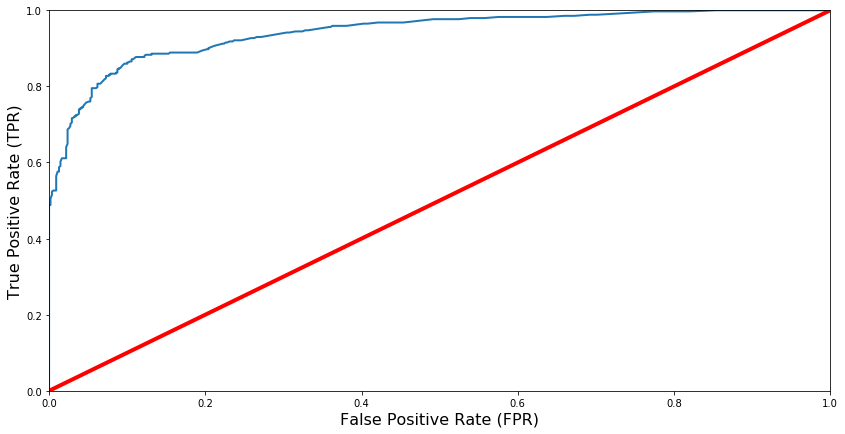

In [120]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

The red line in the middel represents a purely random classifier (e.g a coin flip) and therefore your classifier should be as far away from it as possible. Our Random Forest model seems to do a good job. 

Of course we also have a tradeoff here, because the classifier produces more false positives, the higher the true positive rate is. 

## ROC AUC Score
The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC. 

A classifiers that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.

In [121]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9423113795417506


# **Prediction**

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_prediction
    })
submission.head(10)

# **Summary**

Hope, this will give you ability to apply concepts that you might have learned from textbooks, blogs and various other sources, on a different type of problem. This project had a heavy focus on the data preparation part, since this is what data scientists work on most of their time. 

In next part we will Cover How various AutoML like, H2O, tpot, Auze AutoML etc, enable us to find best fit Model by applying and comparing Score of all the Models/Alorithums discussed above.